In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [5]:
spam_df = pd.read_csv('data/spam.csv',encoding='latin')



print("The number of records in the data is:",len(spam_df.axes[0]))
print("The number of fields in the data is:",len(spam_df.axes[1]))

The number of records in the data is: 5572
The number of fields in the data is: 5


In [6]:

spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:

spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [8]:

spam_df.rename({'v1':'target','v2':'text'},axis=1,inplace=True)


spam_df = spam_df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)


spam_df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:

spam_df['target'] = spam_df['target'].map(dict(spam=1, ham=0))
spam_df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


#### Data checks

In [10]:

spam_df.isnull().sum()

target    0
text      0
dtype: int64

In [11]:

spam_df.duplicated().sum()

403

In [12]:

spam_df = spam_df.drop_duplicates(keep='first')

In [13]:

spam_df.shape

(5169, 2)

#### checking class representation in target column

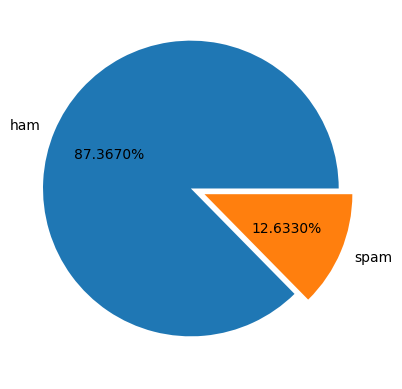

In [14]:
plt.pie(spam_df['target'].value_counts(),labels=['ham','spam'],autopct='%0.4f%%',explode=[0.1,0])
plt.show()

There is class imbalance present in database...

#### lowercase text, tokenization, remove special characters, remove stopwords and punctuation, stemming

In [18]:
import string



ps = PorterStemmer()

def cleaning_text(text):
    text = nltk.word_tokenize(text.lower())
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            stemming = ps.stem(i)
            y.append(stemming)
            
    return " ".join(y)

In [19]:
cleaning_text('Hey!! Did you get my memo from last night?? I am excited to visit you for graduation! yay :)')

'hey get memo last night excit visit graduat yay'

In [20]:
spam_df['cleaned_text'] = spam_df['text'].apply(cleaning_text)

In [21]:
spam_df.head()

,target,text,length,num_words,num_sent,cleaned_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [22]:

spam_df.groupby('target').describe().T

target                     0           1
length    count  4516.000000  653.000000
          mean     70.459256  137.891271
          std      56.358207   30.137753
          min       2.000000   13.000000
          25%      34.000000  132.000000
          50%      52.000000  149.000000
          75%      90.000000  157.000000
          max     910.000000  224.000000
num_words count  4516.000000  653.000000
          mean     17.123782   27.667688
          std      13.493970    7.008418
          min       1.000000    2.000000
          25%       8.000000   25.000000
          50%      13.000000   29.000000
          75%      22.000000   32.000000
          max     220.000000   46.000000
num_sent  count  4516.000000  653.000000
          mean      1.820195    2.970904
          std       1.383657    1.488425
          min       1.000000    1.000000
          25%       1.000000    2.000000
          50%       1.000000    3.000000
          75%       2.000000    4.000000
          max      38.000000    9.000000

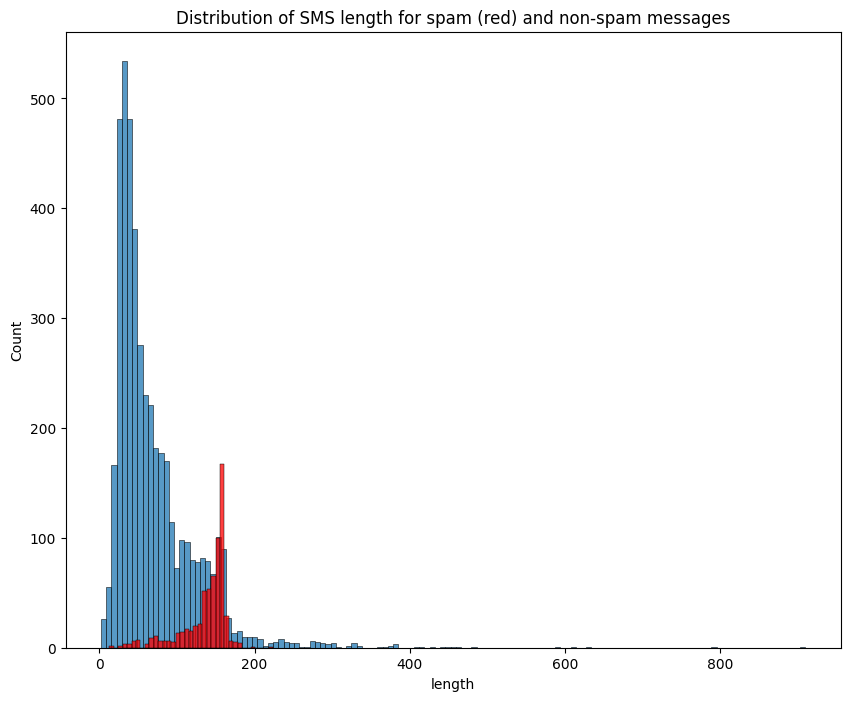

In [23]:

import seaborn as sns
plt.figure(figsize=(10,8))
plt.title('Distribution of SMS length for spam (red) and non-spam messages')
sns.histplot(spam_df[spam_df['target'] == 0]['length'])
sns.histplot(spam_df[spam_df['target'] == 1]['length'],color='red')
plt.show()

#### model building

In [1]:

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
tf = TfidfVectorizer()

In [28]:
tfid_vec = tf.fit(spam_df['cleaned_text'])
sample_x = tf.transform(spam_df['cleaned_text']).toarray()

In [29]:

import pickle


with open('cleaned_text.pkl', 'wb') as file:
    pickle.dump(spam_df['cleaned_text'], file, protocol=4)

In [30]:
X = tf.fit_transform(spam_df['cleaned_text']).toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:

import joblib

joblib.dump(tfid_vec, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [32]:
y = np.array(spam_df['target'])
y

array([0, 0, 1, ..., 0, 0, 0])

In [33]:


from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=258,test_size=0.20)

In [34]:

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (4135, 6708) (4135,)
Test set shape: (1034, 6708) (1034,)


#### making predictions

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [38]:

models = [
    ('Logistic Regression', LogisticRegression(penalty='l1', solver='liblinear')),
    ('SVM', SVC(kernel='sigmoid', gamma=1.0)),
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators=50, random_state=2)),
    ('Extra Trees', ExtraTreesClassifier(n_estimators=50, random_state=2)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=50, random_state=2)),
    ('Bagging', BaggingClassifier(n_estimators=50, random_state=2)),
    ('Gradient Boosting', GradientBoostingClassifier(n_estimators=50, random_state=2)),
    ('XGBoost', XGBClassifier(n_estimators=50, random_state=2))
]

results = {}



for model_name, model in models:
  
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

   
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Confusion Matrix': cm
    }

In [39]:
results

{'Logistic Regression': {'Accuracy': 0.9516441005802708,
  'Precision': 0.8969072164948454,
  'Recall': 0.6850393700787402,
  'F1': 0.7767857142857143,
  'Confusion Matrix': array([[897,  10],
         [ 40,  87]])},
 'SVM': {'Accuracy': 0.9738878143133463,
  'Precision': 0.9629629629629629,
  'Recall': 0.8188976377952756,
  'F1': 0.8851063829787233,
  'Confusion Matrix': array([[903,   4],
         [ 23, 104]])},
 'Multinomial Naive Bayes': {'Accuracy': 0.9632495164410058,
  'Precision': 1.0,
  'Recall': 0.7007874015748031,
  'F1': 0.824074074074074,
  'Confusion Matrix': array([[907,   0],
         [ 38,  89]])},
 'Decision Tree': {'Accuracy': 0.9497098646034816,
  'Precision': 0.8571428571428571,
  'Recall': 0.7086614173228346,
  'F1': 0.7758620689655171,
  'Confusion Matrix': array([[892,  15],
         [ 37,  90]])},
 'K-Nearest Neighbors': {'Accuracy': 0.9081237911025145,
  'Precision': 1.0,
  'Recall': 0.25196850393700787,
  'F1': 0.4025157232704403,
  'Confusion Matrix': array(

In [37]:

results_df = pd.DataFrame.from_dict(results, orient='index')


print(results_df)

                         Accuracy  Precision    Recall        F1  \
Logistic Regression      0.951644   0.896907  0.685039  0.776786   
SVM                      0.973888   0.962963  0.818898  0.885106   
Multinomial Naive Bayes  0.963250   1.000000  0.700787  0.824074   
Decision Tree            0.949710   0.864078  0.700787  0.773913   
K-Nearest Neighbors      0.908124   1.000000  0.251969  0.402516   
Random Forest            0.975822   1.000000  0.803150  0.890830   
Extra Trees              0.980658   0.981982  0.858268  0.915966   
AdaBoost                 0.968085   0.935185  0.795276  0.859574   

                              Confusion Matrix  
Logistic Regression      [[897, 10], [40, 87]]  
SVM                      [[903, 4], [23, 104]]  
Multinomial Naive Bayes   [[907, 0], [38, 89]]  
Decision Tree            [[893, 14], [38, 89]]  
K-Nearest Neighbors       [[907, 0], [95, 32]]  
Random Forest            [[907, 0], [25, 102]]  
Extra Trees              [[905, 2], [18, 109

Precision vs Recall vs F1

precision considers the potential impact of false positives on user experience, productivity, and legal considerations. However, it's important to strike a balance between precision and recall, as overly strict filtering may result in missed spam (false negatives).

recall is also important in a spam classifier to ensure that a high proportion of actual spam instances are captured and correctly classified as spam. By minimizing false negatives, the classifier reduces the risk of missing important spam emails and helps maintain a reliable spam filtering system.

F1 score is a useful metric for spam classification as it offers a balanced assessment of the classifier's performance considering both precision and recall simultaneously. It helps ensure that the classifier effectively identifies spam emails while minimizing false positives, taking into account the specific requirements and objectives of spam classification tasks.


In [40]:

results_df.sort_values(by='F1', ascending=False)

,Accuracy,Precision,Recall,F1,Confusion Matrix
Extra Trees,0.980658,0.981982,0.858268,0.915966,"[[905, 2], [18, 109]]"
Random Forest,0.975822,1.000000,0.803150,0.890830,"[[907, 0], [25, 102]]"
SVM,0.973888,0.962963,0.818898,0.885106,"[[903, 4], [23, 104]]"
AdaBoost,0.968085,0.935185,0.795276,0.859574,"[[900, 7], [26, 101]]"
Multinomial Naive Bayes,0.963250,1.000000,0.700787,0.824074,"[[907, 0], [38, 89]]"
Logistic Regression,0.951644,0.896907,0.685039,0.776786,"[[897, 10], [40, 87]]"
Decision Tree,0.949710,0.864078,0.700787,0.773913,"[[893, 14], [38, 89]]"
K-Nearest Neighbors,0.908124,1.000000,0.251969,0.402516,"[[907, 0], [95, 32]]"


In [41]:
from sklearn.model_selection import GridSearchCV


extra_trees = ExtraTreesClassifier(random_state=2)




param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}




grid_search = GridSearchCV(extra_trees, param_grid, cv=2)
grid_search.fit(X_train, y_train)
print("check")


best_params = grid_search.best_params_

print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

best_estimator = grid_search.best_estimator_


best_estimator.fit(X_train, y_train)


y_pred = best_estimator.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:", cm)

KeyboardInterrupt: 